In [1]:
%load_ext autoreload
%autoreload 2
from tf_activation import DeepGraph
from tf_activation.models import mnist_cff as mnist_model

import math
import random
import os

import networkx as nx
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist_map = {
    0: 3,
    1: 2,
    2: 1,
    3: 18,
    4: 4,
    5: 8,
    6: 11,
    7: 0,
    8: 61,
    9: 7
}

SAVE_PATH = '../logdir/models'
ADV_PATH = '../logdir/adversaries'
ELITE_PATH = '../logdir/elites'
DATA_PATH = '../logdir/data'


mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = True

persistence_module = tf.load_op_library('/home/tgebhart/Projects/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
im_1 = mnist.test.images[mnist_map[1]]
im_2 = mnist.test.images[mnist_map[2]]

steps = 100

columns = ['in_distance_1', 'in_distance_2', 'per_distance_1', 'per_distance_2', 'cross_entropy_1',
           'cross_entropy_2', 'y_conv_1', 'y_conv_2', 'accuracy_1', 'accuracy_2']
index = range(steps)
test_df = pd.DataFrame(index=index, columns=columns)

In [4]:
def create_path(start_im, end_im, steps=100):
    ret = []
    t = np.divide(end_im - start_im, steps)
    for i in range(1,steps+1):
        ret.append(start_im + i*t)
    return ret
    

In [5]:
path = create_path(im_1, im_2)

In [6]:
# setup model
with tf.device('/cpu:0'):
    # Create the model
    x = tf.placeholder(tf.float32, [None, 784])

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 10])

    # Build the graph for the deep net
    net, keep_prob = mnist_model.deepnn(x)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()

In [7]:
# run network
test_labels = np.stack((mnist.test.labels[mnist_map[1]],mnist.test.labels[mnist_map[2]]))
p = 99.999
with tf.Session(config=config) as sess:

    saver.restore(sess, os.path.join(SAVE_PATH, 'mnist_cff_2000.ckpt'))

    test_inputs_1 = np.stack((im_1, path[0]))
    test_inputs_2 = np.stack((im_2, path[0]))

    percentiles = persistence_module.layerwise_percentile([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        [p,p,p])

    ps1_1 = percentiles.eval(feed_dict={x: test_inputs_1[:1], keep_prob:1.0})
    ps1_2 = percentiles.eval(feed_dict={x: test_inputs_2[:1], keep_prob:1.0})
    
    for i in range(len(path)):
        
        test_inputs_1 = np.stack((im_1, path[i]))
        test_inputs_2 = np.stack((im_2, path[i]))
        in_distance_1 = np.linalg.norm(im_1 - path[i], ord=2)
        in_distance_2 = np.linalg.norm(im_2 - path[i], ord=2)

        ps2 = percentiles.eval(feed_dict={x: test_inputs_1[1:], keep_prob:1.0})

        result_1 = persistence_module.bottleneck_distance([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        np.stack((ps1_1, ps2))
                                                        )
        
        result_2 = persistence_module.bottleneck_distance([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        np.stack((ps1_2, ps2))
                                                        )


        per_distance_1 = result_1.eval(feed_dict={x: test_inputs_1, keep_prob:1.0})
        per_distance_2 = result_2.eval(feed_dict={x: test_inputs_2, keep_prob:1.0})
        print('Step: ', i)
        
        ce_1 = cross_entropy.eval(feed_dict={x:test_inputs_1[1:], y_:test_labels[:1], keep_prob:1.0})
        ce_2 = cross_entropy.eval(feed_dict={x:test_inputs_2[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv_1 = sess.run(net['y_conv'], feed_dict={x:test_inputs_1[1:], keep_prob:1.0})
        y_conv_2 = sess.run(net['y_conv'], feed_dict={x:test_inputs_2[1:], keep_prob:1.0})
        acc_1 = accuracy.eval(feed_dict={x:test_inputs_1[1:], y_:test_labels[:1], keep_prob:1})
        acc_2 = accuracy.eval(feed_dict={x:test_inputs_2[1:], y_:test_labels[1:], keep_prob:1})
        y_conv_1 = y_conv_1 / np.linalg.norm(y_conv_1)
        y_conv_2 = y_conv_2 / np.linalg.norm(y_conv_2)

        test_df.loc[i, 'in_distance_1'] = in_distance_1
        test_df.loc[i, 'per_distance_1'] = per_distance_1[0]
        test_df.loc[i, 'cross_entropy_1'] = ce_1
        test_df.loc[i, 'y_conv_1'] = y_conv_1[0,np.argmax(test_labels[0], axis=0)]
        test_df.loc[i, 'accuracy_1'] = acc_1
        
        test_df.loc[i, 'in_distance_2'] = in_distance_2
        test_df.loc[i, 'per_distance_2'] = per_distance_2[0]
        test_df.loc[i, 'cross_entropy_2'] = ce_2
        test_df.loc[i, 'y_conv_2'] = y_conv_2[0,np.argmax(test_labels[1], axis=0)]
        test_df.loc[i, 'accuracy_2'] = acc_2
        

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cff_2000.ckpt
('Step: ', 0)
('Step: ', 1)
('Step: ', 2)
('Step: ', 3)
('Step: ', 4)
('Step: ', 5)
('Step: ', 6)
('Step: ', 7)
('Step: ', 8)
('Step: ', 9)
('Step: ', 10)
('Step: ', 11)
('Step: ', 12)
('Step: ', 13)
('Step: ', 14)
('Step: ', 15)
('Step: ', 16)
('Step: ', 17)
('Step: ', 18)
('Step: ', 19)
('Step: ', 20)
('Step: ', 21)
('Step: ', 22)
('Step: ', 23)
('Step: ', 24)
('Step: ', 25)
('Step: ', 26)
('Step: ', 27)
('Step: ', 28)
('Step: ', 29)
('Step: ', 30)
('Step: ', 31)
('Step: ', 32)
('Step: ', 33)
('Step: ', 34)
('Step: ', 35)
('Step: ', 36)
('Step: ', 37)
('Step: ', 38)
('Step: ', 39)
('Step: ', 40)
('Step: ', 41)
('Step: ', 42)
('Step: ', 43)
('Step: ', 44)
('Step: ', 45)
('Step: ', 46)
('Step: ', 47)
('Step: ', 48)
('Step: ', 49)
('Step: ', 50)
('Step: ', 51)
('Step: ', 52)
('Step: ', 53)
('Step: ', 54)
('Step: ', 55)
('Step: ', 56)
('Step: ', 57)
('Step: ', 58)
('Step: ', 59)
('Step: ', 60)
('Step: ', 61)
(

In [8]:
test_df.head()

,in_distance_1,in_distance_2,per_distance_1,per_distance_2,cross_entropy_1,cross_entropy_2,y_conv_1,y_conv_2,accuracy_1,accuracy_2
0,0.0982534,9.72708,0.035522,0.372171,0.00051926,8.60447,0.888231,0.161409,1,0
1,0.196507,9.62883,0.0630315,0.376033,0.000699395,8.21875,0.883038,0.179205,1,0
2,0.29476,9.53058,0.0699771,0.274287,0.000947741,7.8309,0.876525,0.197712,1,0
3,0.393013,9.43232,0.476206,0.605979,0.00129901,7.44376,0.868596,0.215874,1,0
4,0.491267,9.33407,0.0976026,0.277628,0.00178928,7.06279,0.860023,0.233538,1,0


In [9]:
def regress(X, y, xlab, ylab):
    
    print(X.shape,y.shape)

    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))
    
    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs
    
    ax.scatter(X, y,  color='black')
    ax.plot(X, regr.predict(X), color='blue', linewidth=3)


    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('{} vs {}'.format(xlab, ylab))

    plt.show()


((100, 1), (100,))
('Coefficients: ', array([-0.01507282]))
Mean squared error: 0.02
Variance score: -15.95
R^2: -15.95


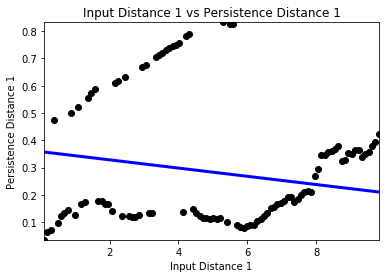

In [11]:
X = test_df['in_distance_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance_1'].as_matrix()
regress(X, y, 'Input Distance 1', 'Persistence Distance 1')

((26, 1), (26,))
('Coefficients: ', array([ 0.27509489]))
Mean squared error: 0.09
Variance score: -1.07
R^2: -1.07


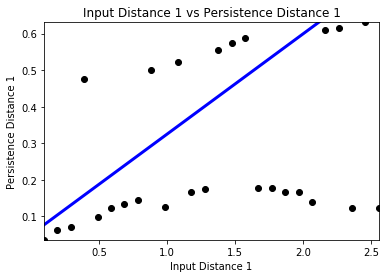

In [19]:
X = test_df['in_distance_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance_1'].as_matrix()
regress(X[:26], y[:26], 'Input Distance 1', 'Persistence Distance 1')

((100, 1), (100,))
('Coefficients: ', array([-0.02047452]))
Mean squared error: 0.03
Variance score: -29.22
R^2: -29.22


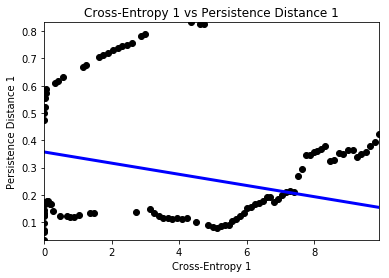

In [12]:
X = test_df['cross_entropy_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Cross-Entropy 1', 'Persistence Distance 1')

((100, 1), (100,))
('Coefficients: ', array([ 0.03691241]))
Mean squared error: 0.01
Variance score: -3.84
R^2: -3.84


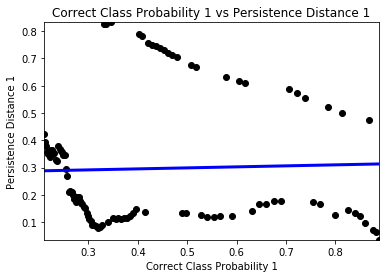

In [13]:
X = test_df['y_conv_1'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Correct Class Probability 1', 'Persistence Distance 1')

((100, 1), (100,))
('Coefficients: ', array([-0.05781046]))
Mean squared error: 0.28
Variance score: -0.31
R^2: -0.31


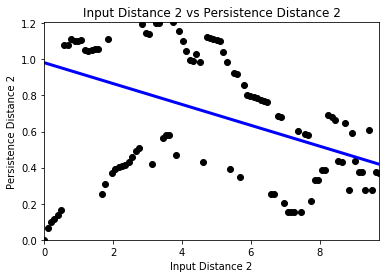

In [14]:
X = test_df['in_distance_2'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance_2'].as_matrix()
regress(X, y, 'Input Distance 2', 'Persistence Distance 2')

((100, 1), (100,))
('Coefficients: ', array([-0.05288483]))
Mean squared error: 0.21
Variance score: -0.00
R^2: -0.00


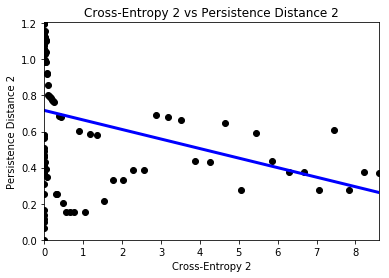

In [15]:
X = test_df['cross_entropy_2'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Cross-Entropy 2', 'Persistence Distance 2')

((100, 1), (100,))
('Coefficients: ', array([ 0.98543546]))
Mean squared error: 0.22
Variance score: -0.01
R^2: -0.01


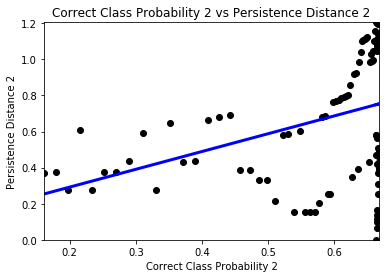

In [16]:
X = test_df['y_conv_2'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Correct Class Probability 2', 'Persistence Distance 2')

In [18]:
test_df[['accuracy_1', 'accuracy_2']]

,accuracy_1,accuracy_2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0
